In [29]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
from sklearn.model_selection import TimeSeriesSplit

# Load the dataset
file_path = 'C:\\Users\\johan\\TDT4259_Data_Science\\consumption_temp.csv'  # Replace with your file path
df = pd.read_csv(file_path)


In [30]:
# Filter data for Oslo
df_oslo = df[df['location'] == 'oslo'].copy()

# Convert 'time' to datetime and sort
df_oslo['time'] = pd.to_datetime(df_oslo['time'])
df_oslo.sort_values('time', inplace=True)

print(df_oslo.head())
print(df_oslo)

print(df_oslo['consumption'].mean())


                  time location  consumption  temperature
1  2022-04-07 21:00:00     oslo     4.092830          1.0
6  2022-04-07 22:00:00     oslo     3.818095          0.4
11 2022-04-07 23:00:00     oslo     3.660981          0.3
16 2022-04-08 00:00:00     oslo     3.584066          0.2
21 2022-04-08 01:00:00     oslo     3.549536          0.4
                     time location  consumption  temperature
1     2022-04-07 21:00:00     oslo     4.092830          1.0
6     2022-04-07 22:00:00     oslo     3.818095          0.4
11    2022-04-07 23:00:00     oslo     3.660981          0.3
16    2022-04-08 00:00:00     oslo     3.584066          0.2
21    2022-04-08 01:00:00     oslo     3.549536          0.4
...                   ...      ...          ...          ...
49466 2023-04-02 17:00:00     oslo    12.410225          5.5
49472 2023-04-02 18:00:00     oslo    12.856381          4.8
49478 2023-04-02 19:00:00     oslo    13.010338          0.6
49484 2023-04-02 20:00:00     oslo    12.7

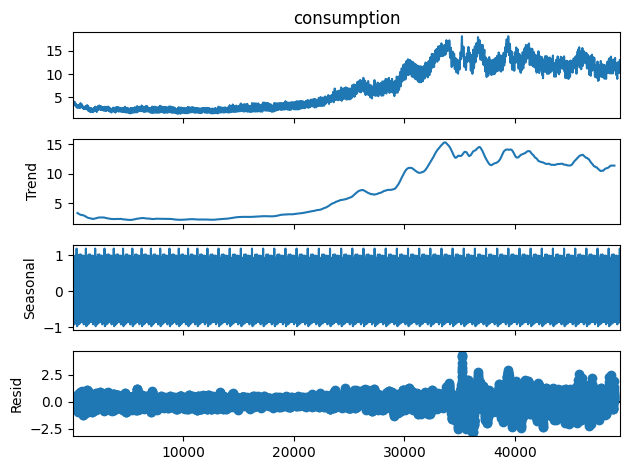

       hour  day_of_week  month  lag24_temperature  rolling_mean_temp_1W  \
1        21            3      4                NaN                   NaN   
6        22            3      4                NaN                   NaN   
11       23            3      4                NaN                   NaN   
16        0            4      4                NaN                   NaN   
21        1            4      4                NaN                   NaN   
...     ...          ...    ...                ...                   ...   
49466    17            6      4                2.1             -1.254762   
49472    18            6      4               -0.2             -1.201786   
49478    19            6      4               -1.7             -1.169643   
49484    20            6      4               -2.6             -1.133333   
49490    21            6      4               -3.4             -1.105952   

       rolling_mean_temp_3D  working_day  
1                       NaN            1  
6

In [31]:
# Generate time-based features
df_oslo['hour'] = df_oslo['time'].dt.hour
df_oslo['day_of_week'] = df_oslo['time'].dt.dayofweek
df_oslo['month'] = df_oslo['time'].dt.month

#generate lagged features
df_oslo['lag7D_consumption'] = df_oslo['consumption'].shift(24*7)
df_oslo['lag24_temperature'] = df_oslo['temperature'].shift(48)
#generate rolling mean features

df_oslo['rolling_mean_temp_1W'] = df_oslo['temperature'].rolling(window=168).mean()
df_oslo['rolling_mean_temp_3D'] = df_oslo['temperature'].rolling(window=72).mean()
#creating binary feature for working day
df_oslo['working_day'] = np.where(df_oslo['day_of_week'] <= 5, 1, 0)
# Prepare features and target





# generate seasonal features based on seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
series = df_oslo['consumption']
result = seasonal_decompose(series, model='additive', period=168)
result.plot()
pyplot.show()

# Add seasonal features to X
df_oslo['seasonal'] = result.seasonal
df_oslo['trend'] = result.trend
df_oslo['residual'] = result.resid

features = ['hour', 'day_of_week', 'month',
              'lag24_temperature', 
              'rolling_mean_temp_1W', 'rolling_mean_temp_3D', 'working_day']

X = df_oslo[features]


print(X)
y = df_oslo['consumption']

In [32]:
# Initialize some variables for the rolling forecast
window_size = 24  # Define the size of the test window (e.g., 30 days)
step_size = 168  # Define the step size for rolling (e.g., 7 days)
n_splits = int((len(X) - window_size) / step_size)

# Initialize the XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)

# Store RMSE for each split
rmse_list = []
mae_list = []

# Rolling Forecast Origin loop
for i in range(n_splits):
    train_end = i * step_size
    test_start = train_end + 1
    test_end = test_start + window_size
    
    X_train, y_train = X.iloc[:train_end], y.iloc[:train_end]
    X_test, y_test = X.iloc[test_start:test_end], y.iloc[test_start:test_end]
    
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mae_list.append(mae)
    print(f"Split {i+1}, MAE: {mae}")
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    rmse_list.append(rmse)
    print(f"Split {i+1}, RMSE: {rmse}")
    #print model feature importance
    featureImportances = []
    for i in range(len(xgb_model.feature_importances_)):
        featureImportances.append(features[i]  + str(xgb_model.feature_importances_[i]))
    print(featureImportances)
# Final model training on the entire dataset
xgb_model.fit(X, y)


# Average RMSE
print("Average RMSE across all splits:", np.mean(rmse_list))
print("Average MAE across all splits:", np.mean(mae_list))

#print mean of consumption
print(df_oslo['consumption'].mean())




Split 1, MAE: 3.844390166666667
Split 1, RMSE: 3.8503018209223114
['hour0.0', 'day_of_week0.0', 'month0.0', 'lag24_temperature0.0', 'rolling_mean_temp_1W0.0', 'rolling_mean_temp_3D0.0', 'working_day0.0']
Split 2, MAE: 0.38006147177251154
Split 2, RMSE: 0.4301332189062959
['hour0.11479591', 'day_of_week0.11250678', 'month0.0', 'lag24_temperature0.6996884', 'rolling_mean_temp_1W0.0', 'rolling_mean_temp_3D0.073008895', 'working_day0.0']
Split 3, MAE: 0.14305394775009153
Split 3, RMSE: 0.16505901454335556
['hour0.04195112', 'day_of_week0.027876519', 'month0.0', 'lag24_temperature0.1054598', 'rolling_mean_temp_1W0.8006732', 'rolling_mean_temp_3D0.024039384', 'working_day0.0']
Split 4, MAE: 0.10756927383232108
Split 4, RMSE: 0.12859796699280374
['hour0.058369152', 'day_of_week0.048225086', 'month0.0', 'lag24_temperature0.08096827', 'rolling_mean_temp_1W0.6934922', 'rolling_mean_temp_3D0.11894533', 'working_day0.0']
Split 5, MAE: 0.12255826504007977
Split 5, RMSE: 0.14399278023265738
['hour0.

In [33]:
#do the same for trondheim
df_trondheim = df[df['location'] == 'trondheim'].copy()

# Convert 'time' to datetime and sort
df_trondheim['time'] = pd.to_datetime(df_trondheim['time'])
df_trondheim.sort_values('time', inplace=True)

print(df_trondheim.head())
print(df_trondheim)

print(df_trondheim['consumption'].mean())



# Generate time-based features
df_trondheim['hour'] = df_trondheim['time'].dt.hour
df_trondheim['day_of_week'] = df_trondheim['time'].dt.dayofweek
df_trondheim['month'] = df_trondheim['time'].dt.month

#generate lagged features
df_trondheim['lag7D_consumption'] = df_trondheim['consumption'].shift(24*7)
df_trondheim['lag24_temperature'] = df_trondheim['temperature'].shift(48)
#generate rolling mean features

df_trondheim['rolling_mean_temp_1W'] = df_trondheim['temperature'].rolling(window=168).mean()
df_trondheim['rolling_mean_temp_3D'] = df_trondheim['temperature'].rolling(window=72).mean()
#creating binary feature for working day
df_trondheim['working_day'] = np.where(df_trondheim['day_of_week'] <= 5, 1, 0)
# Prepare features and target
features = ['temperature', 'hour', 'day_of_week', 'month',
              'lag24_temperature', 
              'rolling_mean_temp_1W', 'rolling_mean_temp_3D', 'working_day', 'lag7D_consumption']

X = df_trondheim[features]
print(X)
y = df_trondheim['consumption']

# Initialize some variables for the rolling forecast
window_size = 24  # Define the size of the test window (e.g., 30 days)
step_size = 47  # Define the step size for rolling (e.g., 7 days)
n_splits = int((len(X) - window_size) / step_size)

# Initialize the XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)

# Store RMSE for each split
rmse_list = []
mae_list = []

# Rolling Forecast Origin loop
for i in range(n_splits):
    train_end = i * step_size
    test_start = train_end + 1
    test_end = test_start + window_size
    
    X_train, y_train = X.iloc[:train_end], y.iloc[:train_end]
    X_test, y_test = X.iloc[test_start:test_end], y.iloc[test_start:test_end]
    
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mae_list.append(mae)
    print(f"Split {i+1}, MAE: {mae}")
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    rmse_list.append(rmse)
    print(f"Split {i+1}, RMSE: {rmse}")
    #print model feature importance
    featureImportances = []
    for i in range(len(xgb_model.feature_importances_)):
        featureImportances.append(features[i]  + str(xgb_model.feature_importances_[i]))
    print(featureImportances)
# Final model training on the entire dataset
xgb_model.fit(X, y)


# Average RMSE
print("Average RMSE across all splits:", np.mean(rmse_list))
print("Average MAE across all splits:", np.mean(mae_list))

#print mean of consumption
print(df_trondheim['consumption'].mean())


                  time   location  consumption  temperature
4  2022-04-07 21:00:00  trondheim     1.970098         -2.8
9  2022-04-07 22:00:00  trondheim     1.839443         -3.3
14 2022-04-07 23:00:00  trondheim     1.747675         -3.8
19 2022-04-08 00:00:00  trondheim     1.703176         -4.2
24 2022-04-08 01:00:00  trondheim     1.694300         -4.1
                     time   location  consumption  temperature
4     2022-04-07 21:00:00  trondheim     1.970098         -2.8
9     2022-04-07 22:00:00  trondheim     1.839443         -3.3
14    2022-04-07 23:00:00  trondheim     1.747675         -3.8
19    2022-04-08 00:00:00  trondheim     1.703176         -4.2
24    2022-04-08 01:00:00  trondheim     1.694300         -4.1
...                   ...        ...          ...          ...
49469 2023-04-02 17:00:00  trondheim     3.927136          3.6
49475 2023-04-02 18:00:00  trondheim     4.067940          3.0
49481 2023-04-02 19:00:00  trondheim     4.093120          1.4
49487 2023